<a href="https://colab.research.google.com/github/marcusnk237/lstm_har/blob/main/LSTM_HAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <a title="Activity Recognition" href="https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition" > LSTMs for Human Activity Recognition</a>

Human Activity Recognition (HAR) using smartphones dataset and an LSTM RNN. Classifying the type of movement amongst six categories:
- WALKING,
- WALKING_UPSTAIRS,
- WALKING_DOWNSTAIRS,
- SITTING,
- STANDING,
- LAYING.

### Importing Libraries

In [2]:
!pip install tensorflow_addons
import cv2
import gc
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from subprocess import call

import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow_addons.optimizers import CyclicalLearningRate
from tensorflow.keras import Model,Sequential,regularizers
from tensorflow.keras.layers import MaxPool1D , Dense, Conv1D , Input , GaussianNoise , MaxPooling1D , LSTM, Flatten , add , Dropout , BatchNormalization , ReLU , GlobalAveragePooling1D

import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold,StratifiedShuffleSplit
from sklearn.metrics import classification_report
from sklearn.utils import resample,shuffle
from scipy import stats
from sklearn.preprocessing import StandardScaler

from collections import Counter
from imblearn.over_sampling import SMOTE
from random import choice
import random 
# Generate and plot a synthetic imbalanced classification dataset
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn')
import numpy as np
import pandas as pd
import gc
#### Import libraries

import itertools
import logging

# detect and init the TPU 
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
# Set random seed
np.random.seed(123)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.8 MB/s 


In [46]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Functions

### Plotting confusion matrix:
This function prints and plots the confusion matrix.
Normalization can be applied by setting `normalize=True`.

In [66]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('/content/drive/MyDrive/RESVIDLSTM/Models/HAR/{}.jpg'.format(title), format='jpg', dpi=300)

### Plotting metrics curves
This function prints and plots the training and test loss curve, as well as the training and test accuracy curve

In [67]:
def metrics_plot(history, field, fn):
    def plot(data, val_data, best_index, best_value, title):
        plt.plot(range(1, len(data)+1), data, label='train')
        plt.plot(range(1, len(data)+1), val_data, label='validation')
        if not best_index is None:
            plt.axvline(x=best_index+1, linestyle=':', c="#777777")
        if not best_value is None:
            plt.axhline(y=best_value, linestyle=':', c="#777777")
        plt.xlabel('Epoch')
        plt.ylabel(field)
        plt.xticks(range(0, len(data), 20))
        plt.title(title)
        plt.legend()
        plt.savefig('/content/drive/MyDrive/RESVIDLSTM/Models/HAR/{}.jpg'.format(field), format='jpg', dpi=300)
        plt.show()
        
        
    try:
       data = history.history[field]
       val_data = history.history['val_' + field]
    except:
       data = history[field]
       val_data = history['val_' + field]
    tail = int(0.15 * len(data))

    best_index = fn(val_data)
    best_value = val_data[best_index]

    plot(data, val_data, best_index, best_value, "{} over epochs (best {:06.4f})".format(field, best_value))
    #plot(data[-tail:], val_data[-tail:], None, best_value, "{} over last {} epochs".format(field, tail))

### Human activity recognition model

In [77]:
def get_har_model(timesteps, input_dim):    
    inputs_cnn=keras.layers.Input(shape=(timesteps, input_dim), name='inputs_cnn')
    pool4 = keras.layers.LSTM(128,return_sequences=True)(inputs_cnn)
    pool4=  keras.layers.Dropout(0.5)(pool4)
    pool4 = keras.layers.LSTM(128,return_sequences=True)(pool4)
    pool4=  keras.layers.Dropout(0.5)(pool4)
    pool4=keras.layers.Flatten()(pool4)
    pool4 = keras.layers.Dense(64, activation='relu')(pool4)
    main_output = keras.layers.Dense(n_classes, activation='softmax', name='main_output')(pool4)
    model = keras.Model(inputs= inputs_cnn, outputs=main_output)
    return model

## Preparing dataset

### Signals labels

In [3]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 


### Downloading datas

In [4]:
print("")

print("Downloading...")
if not os.path.exists("UCI HAR Dataset.zip"):
    call(
        'wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI HAR Dataset.zip"',
        shell=True
    )
    print("Downloading done.\n")
else:
    print("Dataset already downloaded. Did not download twice.\n")


print("Extracting...")
extract_directory = os.path.abspath("UCI HAR Dataset")
if not os.path.exists(extract_directory):
    call(
        'unzip -nq "UCI HAR Dataset.zip"',
        shell=True
    )
    print("Extracting successfully done to {}.".format(extract_directory))
else:
    print("Dataset already extracted. Did not extract twice.\n")


Downloading...

Extracting...
Extracting successfully done to /content/UCI HAR Dataset.


### Loading datas

In [5]:
TRAIN = "train/"
TEST = "test/"

DATASET_PATH='/content/UCI HAR Dataset/'
# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


### Training and test datas
Since to training isn't sufficient enough (Around 70% of the global dataset), we processed as follow:
- We reassemble the dataset
- Then, we split it into: Training dataset, test dataset and validation dataset

##### Reassembling data

In [ ]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep
n_classes = len(LABELS)

In [10]:
X=np.concatenate((X_train,X_test),axis=0) ### Reassembling datas ( features)
Y=np.concatenate((y_train,y_test), axis=0) ### Reassembling datas ( labels)
Y= np.array([i[0] for i in Y])

##### Split into train, test and validation

In [91]:
Y=Y.astype(int) # Convert label into int
## Split into train and test
X_train, X_val, y_train, y_val = train_test_split(X,Y, test_size=0.1, random_state=np.random.randint(1,1000, 1)[0], shuffle = True)
## Slip into test and validation
X_val, X_test, y_val, y_test  = train_test_split(X_val, y_val, test_size=0.5, random_state=np.random.randint(1,1000, 1)[0], shuffle = True)

## Training and Testing

### Training

In [92]:
name_weights = "human_activity_recognition_weights.h5"
N=X_train.shape[0]
batch_size = 32 * tpu_strategy.num_replicas_in_sync
iterations = N/batch_size
step_size= 2 * iterations
lr_schedule = CyclicalLearningRate(1e-6, 1e-3, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
print(batch_size) 
with tpu_strategy.scope():
        har_model = get_har_model(X_train.shape[1],X_train.shape[2]) # Instanciate ResVidNet
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2) # Early stopping parameters
        save_best_weights = ModelCheckpoint(filepath="/content/drive/MyDrive/RESVIDLSTM/Models/HAR/"+name_weights, verbose=2, save_best_only=True , restore_best_weights=True) # Model checkpoint parameters
        har_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy']) # Model compiling
history = har_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=100, shuffle=False,callbacks=[save_best_weights,early_stopping])
np.save("/content/drive/MyDrive/RESVIDLSTM/Models/HAR/har_history_.npy",history.history)

256
Epoch 1/100
37/37 [==============================] - ETA: 0s - loss: 1.3042 - accuracy: 0.4619
Epoch 1: val_loss improved from inf to 0.89562, saving model to /content/drive/MyDrive/RESVIDLSTM/Models/HAR/human_activity_recognition_weights.h5
37/37 [==============================] - 15s 207ms/step - loss: 1.3042 - accuracy: 0.4619 - val_loss: 0.8956 - val_accuracy: 0.5903
Epoch 2/100
37/37 [==============================] - ETA: 0s - loss: 0.7062 - accuracy: 0.7060
Epoch 2: val_loss improved from 0.89562 to 0.40274, saving model to /content/drive/MyDrive/RESVIDLSTM/Models/HAR/human_activity_recognition_weights.h5
37/37 [==============================] - 2s 55ms/step - loss: 0.7062 - accuracy: 0.7060 - val_loss: 0.4027 - val_accuracy: 0.8447
Epoch 3/100
37/37 [==============================] - ETA: 0s - loss: 0.3360 - accuracy: 0.8775
Epoch 3: val_loss improved from 0.40274 to 0.23149, saving model to /content/drive/MyDrive/RESVIDLSTM/Models/HAR/human_activity_recognition_weights.h5


### Testing

In [93]:
har_model.load_weights("/content/drive/MyDrive/RESVIDLSTM/Models/HAR/"+name_weights) 
X_covid_test = har_model.evaluate(X_val, y_val) # Evaluate model

17/17 [==============================] - 1s 21ms/step - loss: 0.1142 - accuracy: 0.9573


### Plotting metrics

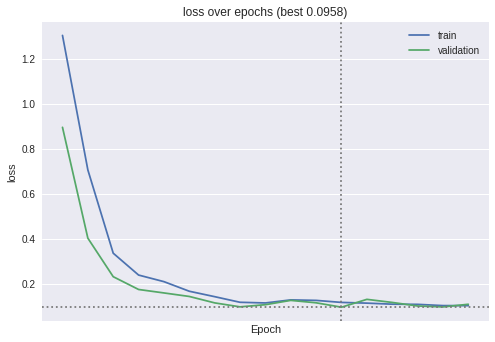

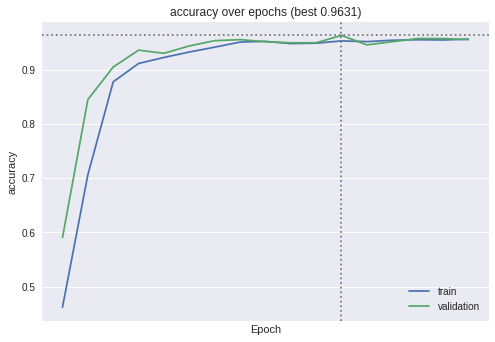

In [94]:
metrics_plot(history, 'loss', lambda x: np.argmin(x))
metrics_plot(history, 'accuracy', lambda x: np.argmax(x))

### Confusion matrix

17/17 [==============================] - 3s 92ms/step
Confusion matrix, without normalization
[[ 90   0   0   0   1   0]
 [  0  77   0   0   0   0]
 [  0   0  60   0   0   0]
 [  0   0   0  87   9   0]
 [  0   0   0  12  68   0]
 [  0   0   0   0   0 111]]


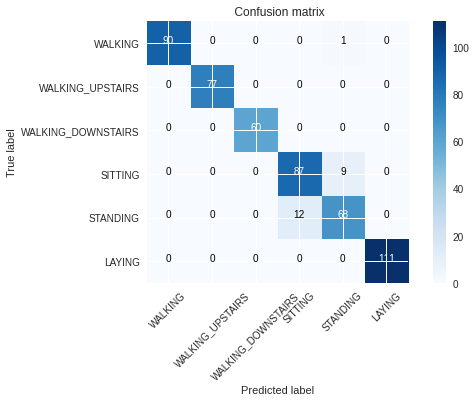

In [95]:
y_pred = tf.argmax(har_model.predict(X_val), axis=-1)
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_val, y_pred)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=LABELS,title=' Confusion matrix')

### Classification report

In [96]:
df_class_r = pd.DataFrame(classification_report(y_pred, y_val, digits=2,output_dict=True)).T
df_class_r['support'] = df_class_r.support.apply(int)
df_class_r.rename(index={'0':LABELS[0], '1':LABELS[1], '2':LABELS[2] ,'3':LABELS[3],'4': LABELS[4],'5': LABELS[5]}, inplace=True)
df_r= df_class_r
df_r.style.background_gradient(cmap='viridis')

,precision,recall,f1-score,support
WALKING,0.989011,1.000000,0.994475,90
WALKING_UPSTAIRS,1.000000,1.000000,1.000000,77
WALKING_DOWNSTAIRS,1.000000,1.000000,1.000000,60
SITTING,0.906250,0.878788,0.892308,99
STANDING,0.850000,0.871795,0.860759,78
LAYING,1.000000,1.000000,1.000000,111
accuracy,0.957282,0.957282,0.957282,0
macro avg,0.957543,0.958430,0.957924,515
weighted avg,0.957339,0.957282,0.957244,515
